# CNN for Coordinate Localization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

def build_coordinate_regressor(image_size=15):
    """
    Returns a CNN model that outputs (x, y) as floats (regression).
    - 4+ convolutional layers
    - MaxPooling after some layers
    - Dropout in the Dense layer
    - MSE as the loss
    """

    # Input shape: (15, 15, 1) for single-band (grayscale) images
    input_shape = (image_size, image_size, 1)

    model = models.Sequential()

    # Convolution layers:(these first two form a "block" before pooling)
    model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape))  
    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))  # reduces spatial size roughly by half

    # Another block of conv layers
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    # shape should now be (1,1,128) if 15x15 -> see shape check below

    # Flatten to get a feature vector
    model.add(layers.Flatten())

    # Dense layers: 64 units, then final 2 for x,y
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(2, activation='linear'))  # final outputs: (x, y)

    #compile for regression with MSE loss
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

def train_on_synthetic(model):
    """
    Loads the synthetic data (15x15 images and (x,y) centers),
    expands dims to (N,15,15,1), then trains the model.
    """
    asteroid_ims = np.load("./TrainingData/TrueSet/Final_True_Bkg_parts/447k_Synth_Images_June23_snr3_V1.npy")  # shape (N, 15, 15) or (N, 15, 15, 1)
    asteroid_coords = np.load("./TrainingData/TrueSet/Final_True_Bkg_parts/447k_Centers_June23_snr3_V1.npy")     # shape (N, 2)

    # Ensure the images have shape (N, 15, 15, 1)
    if asteroid_ims.ndim == 3:
        asteroid_ims = np.expand_dims(asteroid_ims, axis=-1)

    print("Synthetic Images shape:", asteroid_ims.shape)
    print("Synthetic Coords shape:", asteroid_coords.shape)

    # Train
    model.fit(
        asteroid_ims,
        asteroid_coords, 
        epochs=10, 
        batch_size=32,
        validation_split=0.2
    )


def evaluate_on_real(model):

    # real_asteroids = np.load("./.npy")            # shape (M, 15, 15)
    # real_asteroids_coords = np.load("./feb15_dimRealsCoords.npy")  # shape (M, 2)
    # real_asteroids_coords = [[7.5 - x, 7.5 - y] for [x, y] in real_asteroids_coords]
    # real_asteroids_coords = np.array(real_asteroids_coords)


    real_asteroids = np.load("../2025Work/15px_W2_masks_real_asteroids_randomized.npy")             # shape (N, 15, 15) or (N, 15, 15, 1)
    real_asteroids_coords = np.load("../2025Work/15px_W2_masks_randomized_coords.npy")
    
    if real_asteroids.ndim == 3:
        real_asteroids = np.expand_dims(real_asteroids, axis=-1)

    print("Real Images shape:", real_asteroids.shape)
    print("Real Coords shape:", real_asteroids_coords.shape)

    # Evaluate on real data
    results = model.evaluate(real_asteroids, real_asteroids_coords, verbose=1)
    print(f"Test MSE: {results[0]:.3f}, Test MAE: {results[1]:.3f}")

    plot_regression_predictions(model, real_asteroids, real_asteroids_coords, start_index=0, num_samples=4)

def plot_regression_predictions(model, images, coords_true, start_index=0, num_samples=10):
    """
    Plots a few real images with their predicted vs. true (x,y) asteroid locations.
    """
    if images.ndim == 3:
        images = np.expand_dims(images, axis=-1)

    preds = model.predict(images)

    fig, axes = plt.subplots(1, num_samples, figsize=(4*num_samples, 4))
    if num_samples == 1:
        axes = [axes]  # to make iteration consistent

    for i in range(num_samples):
        idx = start_index + i
        if idx >= len(images):
            break

        img_2d = images[idx, :, :, 0]
        x_true, y_true = coords_true[idx]
        x_pred, y_pred = preds[idx]

        ax = axes[i]
        ax.imshow(img_2d, origin='lower', cmap='gray')

        # Mark ground truth in green, predicted in red
        ax.scatter(x_true, y_true, marker='.', color='green', label='True')
        ax.scatter(x_pred, y_pred, marker='x', color='red', label='Pred')

        ax.set_xlim(-0.5, 14.5)
        ax.set_ylim(-0.5, 14.5)
        ax.set_title(f"Idx={idx}\nT=({x_true:.1f},{y_true:.1f})\nP=({x_pred:.1f},{y_pred:.1f})")
        ax.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Build the CNN with 4+ conv layers, maxpooling, dropout
    model = build_coordinate_regressor(image_size=15)
    model.summary()

    # Train on synthetic data
    train_on_synthetic(model)

    # Evaluate on real data
    # evaluate_on_real(model)


2025-06-25 05:08:25.857071: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-25 05:08:26.969627: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 13, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 5, 5, 32)          0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 1, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                        

2025-06-25 05:08:28.682922: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4356 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5
2025-06-25 05:08:28.683594: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1210 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:17:00.0, compute capability: 7.5


Synthetic Images shape: (447748, 15, 15, 1)
Synthetic Coords shape: (447748, 2)
Epoch 1/10


2025-06-25 05:08:30.862160: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2025-06-25 05:08:30.967794: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-06-25 05:08:31.104241: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f38c4087de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-25 05:08:31.104304: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-06-25 05:08:31.104320: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2025-06-25 05:08:31.114512: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-25 05:08:31.196008: I tensorflow/tsl/platf

11194/11194 [==============================] - 66s 6ms/step - loss: 3.3192 - mae: 1.1578 - val_loss: 0.7621 - val_mae: 0.4884
Epoch 2/10
11194/11194 [==============================] - 71s 6ms/step - loss: 1.2340 - mae: 0.7569 - val_loss: 0.6009 - val_mae: 0.4513
Epoch 3/10
 2379/11194 [=====>........................] - ETA: 53s - loss: 1.0653 - mae: 0.7052

KeyboardInterrupt: 

In [2]:
model.save("v1_asteroid_coord_regressor.keras")

In [10]:
evaluate_on_real(model)

# Plotting test results on real data

4/4 [==============================] - 0s 2ms/step


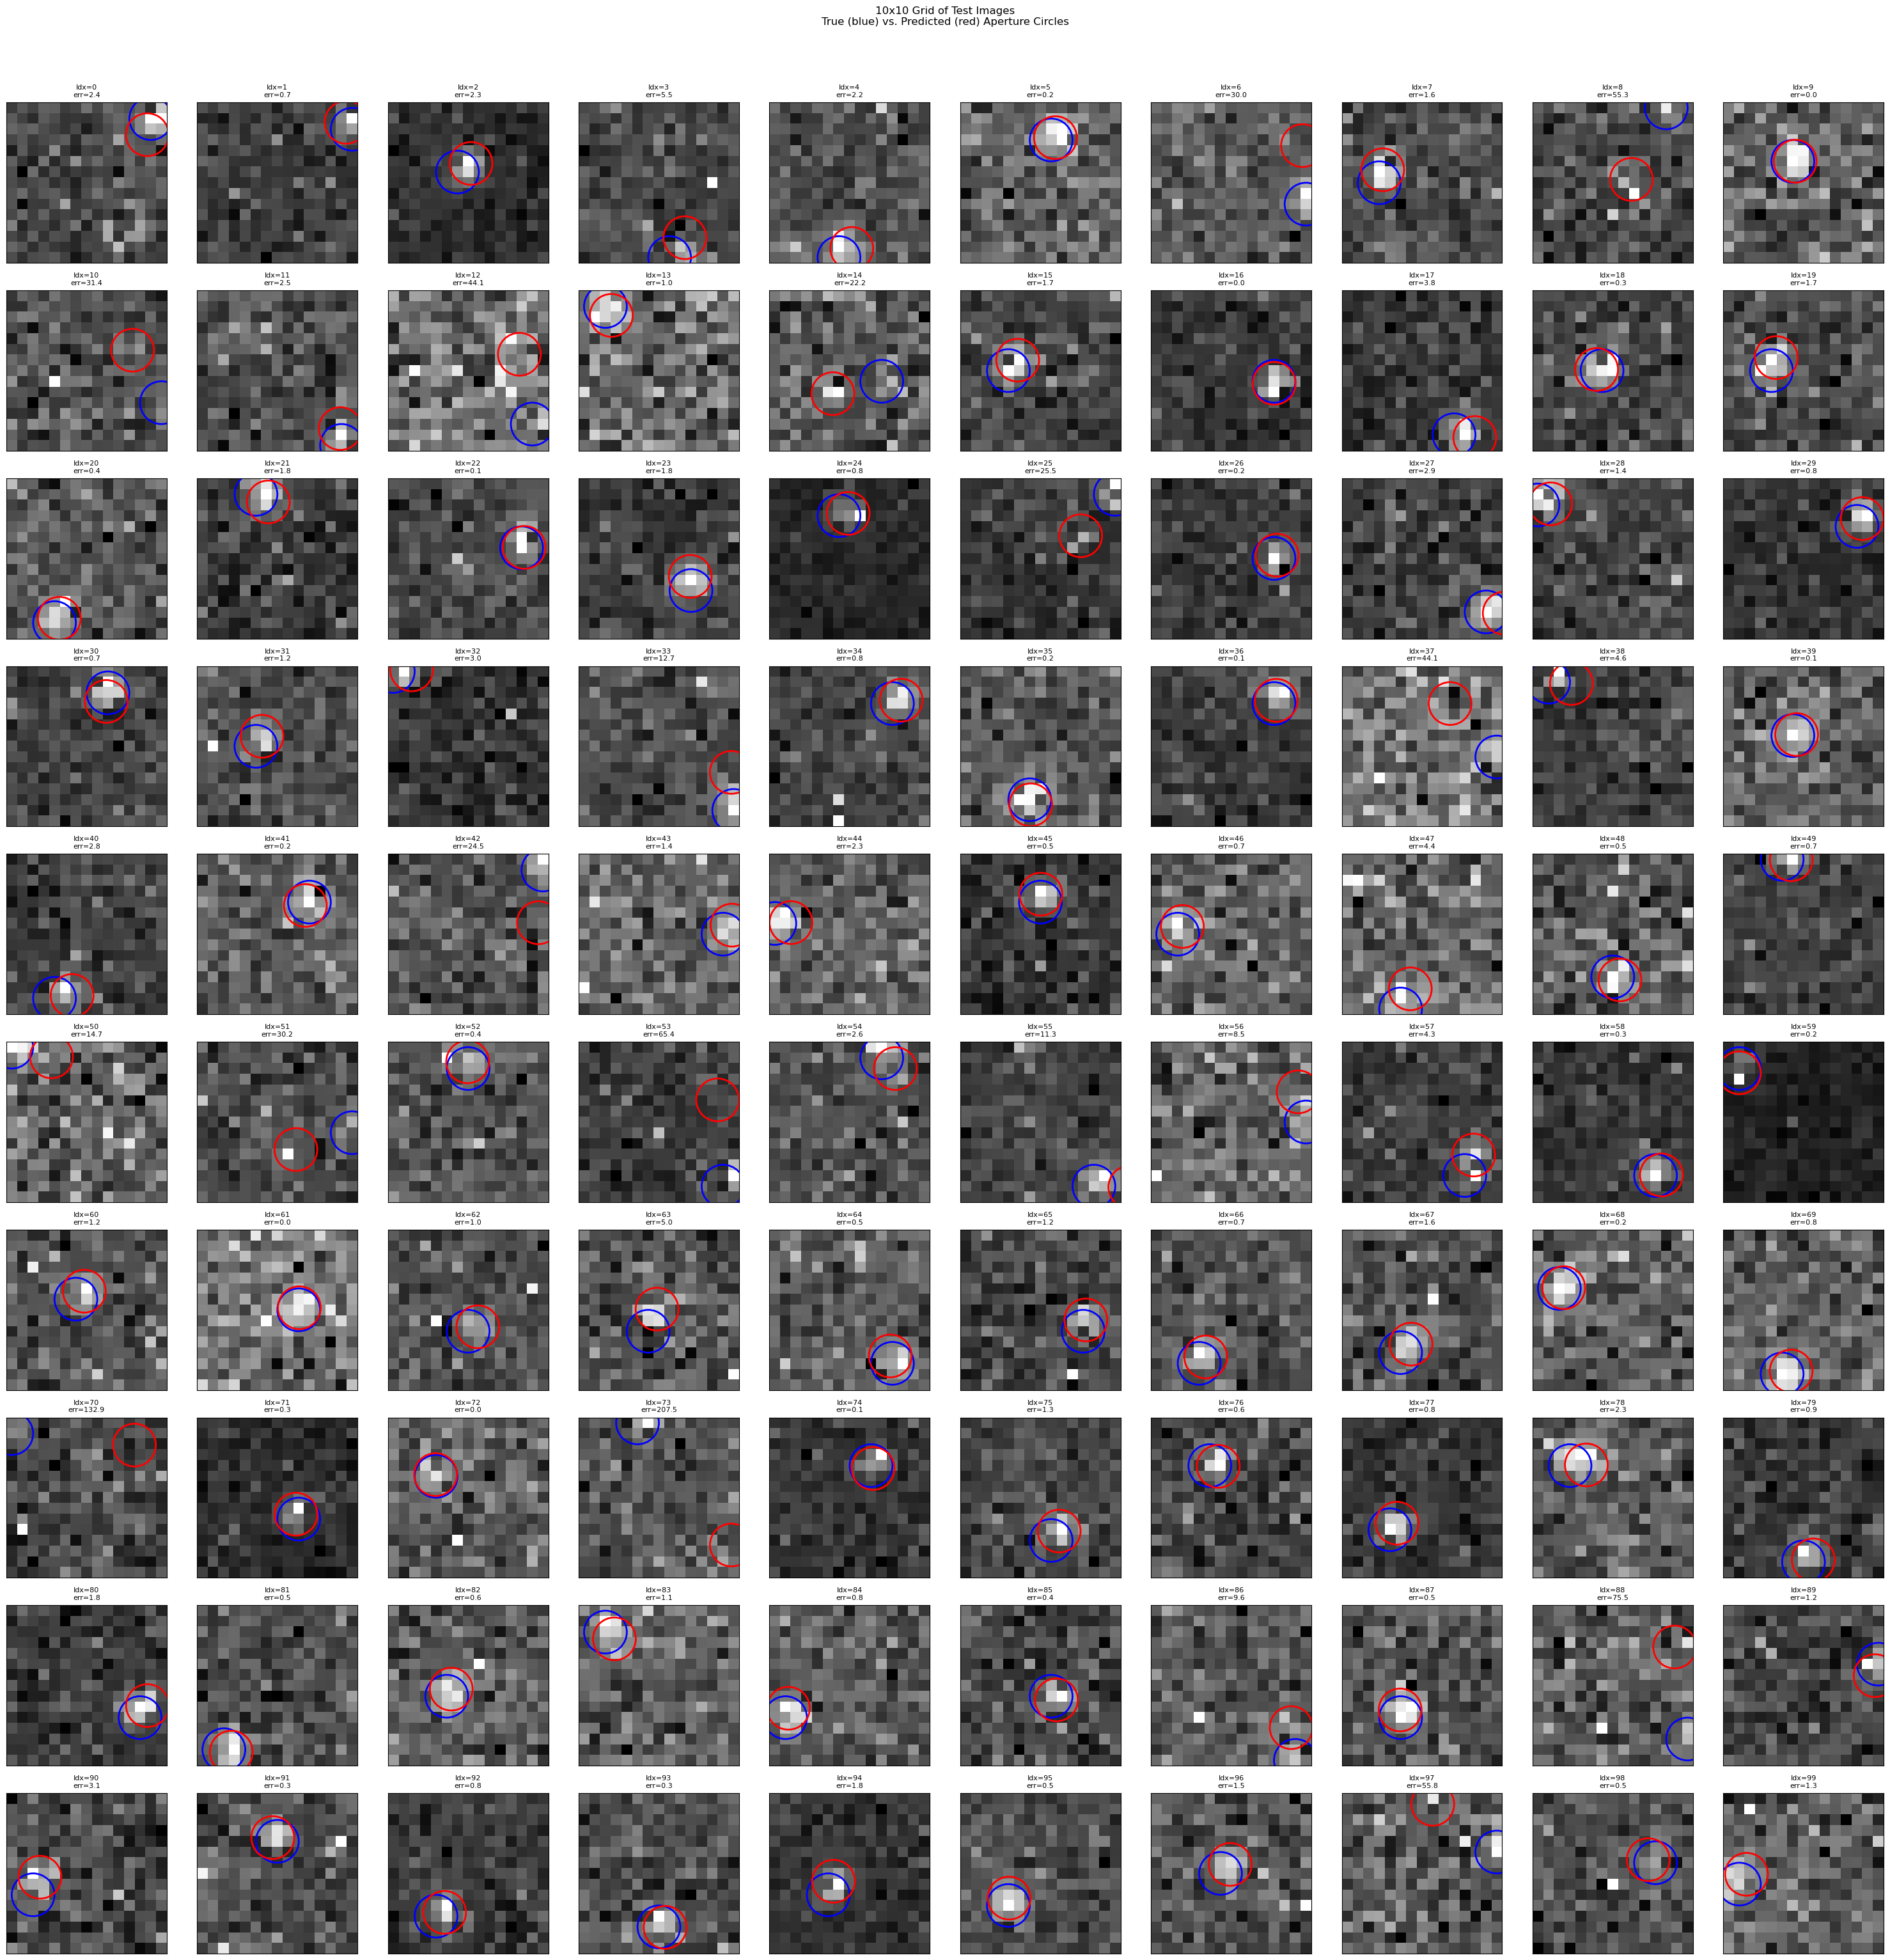

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_10x10_aperture_circles(model, test_images, test_coords, start_index=0, radius=2.0):

    # Ensure images have shape (N, 15, 15, 1)
    if test_images.ndim == 3:
        test_images = np.expand_dims(test_images, axis=-1)

    # Get model predictions
    preds = model.predict(test_images)

    # Prepare 10x10 grid
    nrows, ncols = 10, 10
    num_subplots = nrows * ncols
    end_index = min(start_index + num_subplots, len(test_images))
    actual_num = end_index - start_index

    fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
    axes = axes.flatten()

    for i in range(num_subplots):
        ax = axes[i]
        idx = start_index + i
        
        if idx >= end_index:
            ax.axis('off')
            continue

        img_2d = test_images[idx, :, :, 0]
        x_true, y_true = test_coords[idx]
        x_pred, y_pred = preds[idx]

        ax.imshow(img_2d, origin='lower', cmap='gray')
        ax.set_xlim(-0.5, 14.5)
        ax.set_ylim(-0.5, 14.5)
        ax.set_xticks([])
        ax.set_yticks([])

        # Create aperture circle patches
        true_circle = patches.Circle(
            (x_true, y_true),
            radius=radius,
            fill=False,
            edgecolor='blue',
            linewidth=2.0,
        )
        pred_circle = patches.Circle(
            (x_pred, y_pred),
            radius=radius,
            fill=False,
            edgecolor='red',
            linewidth=2.0,
        )

        # Add the circles to the subplot
        ax.add_patch(true_circle)
        ax.add_patch(pred_circle)

        # Compute and display squared error
        dx = x_pred - x_true
        dy = y_pred - y_true
        sq_err = dx*dx + dy*dy
        ax.set_title(f"Idx={idx}\nerr={sq_err:.1f}", fontsize=8)

    fig.suptitle("10x10 Grid of Test Images\nTrue (blue) vs. Predicted (red) Aperture Circles", y=1.02)
    plt.tight_layout()
    plt.show()



real_asteroids = np.load("../2025Work/15px_W2_masks_real_asteroids_randomized.npy")             # shape (N, 15, 15) or (N, 15, 15, 1)
real_asteroids_coords = np.load("../2025Work/15px_W2_masks_randomized_coords.npy")



plot_10x10_aperture_circles(
    model=model,
    test_images=real_asteroids,
    test_coords=real_asteroids_coords,
    start_index=0,
    radius=2.0
)


# Blind Search

In [11]:
from tensorflow.keras.models import load_model

model = load_model("v1_asteroid_coord_regressor.keras")

In [ ]:
"""
take in pos images

output array of predicted locations

turn each loc into ra, dec

save ras, decs into npy for linking

In [12]:
from kevlib.utils.io import mmcreate, mmload
import numpy as np
import tensorflow as tf

cs = np.load("./Searches/v3_all_confidences_S1.npy")
detIndexes = [i for i in range(len(cs)) if cs[i] >= 0.4]

all_search = mmload("./Searches/2_S1_DarkPixelsRemoved_Normalized_FinalDeployGrids.npy")

pt4_ims = [all_search[i] for i in range(len(all_search)) if i in detIndexes]

# np.save("./Searches/v3_images_pt4.npy", pt4_ims)

KeyboardInterrupt: 

4789/4789 [==============================] - 7s 1ms/step


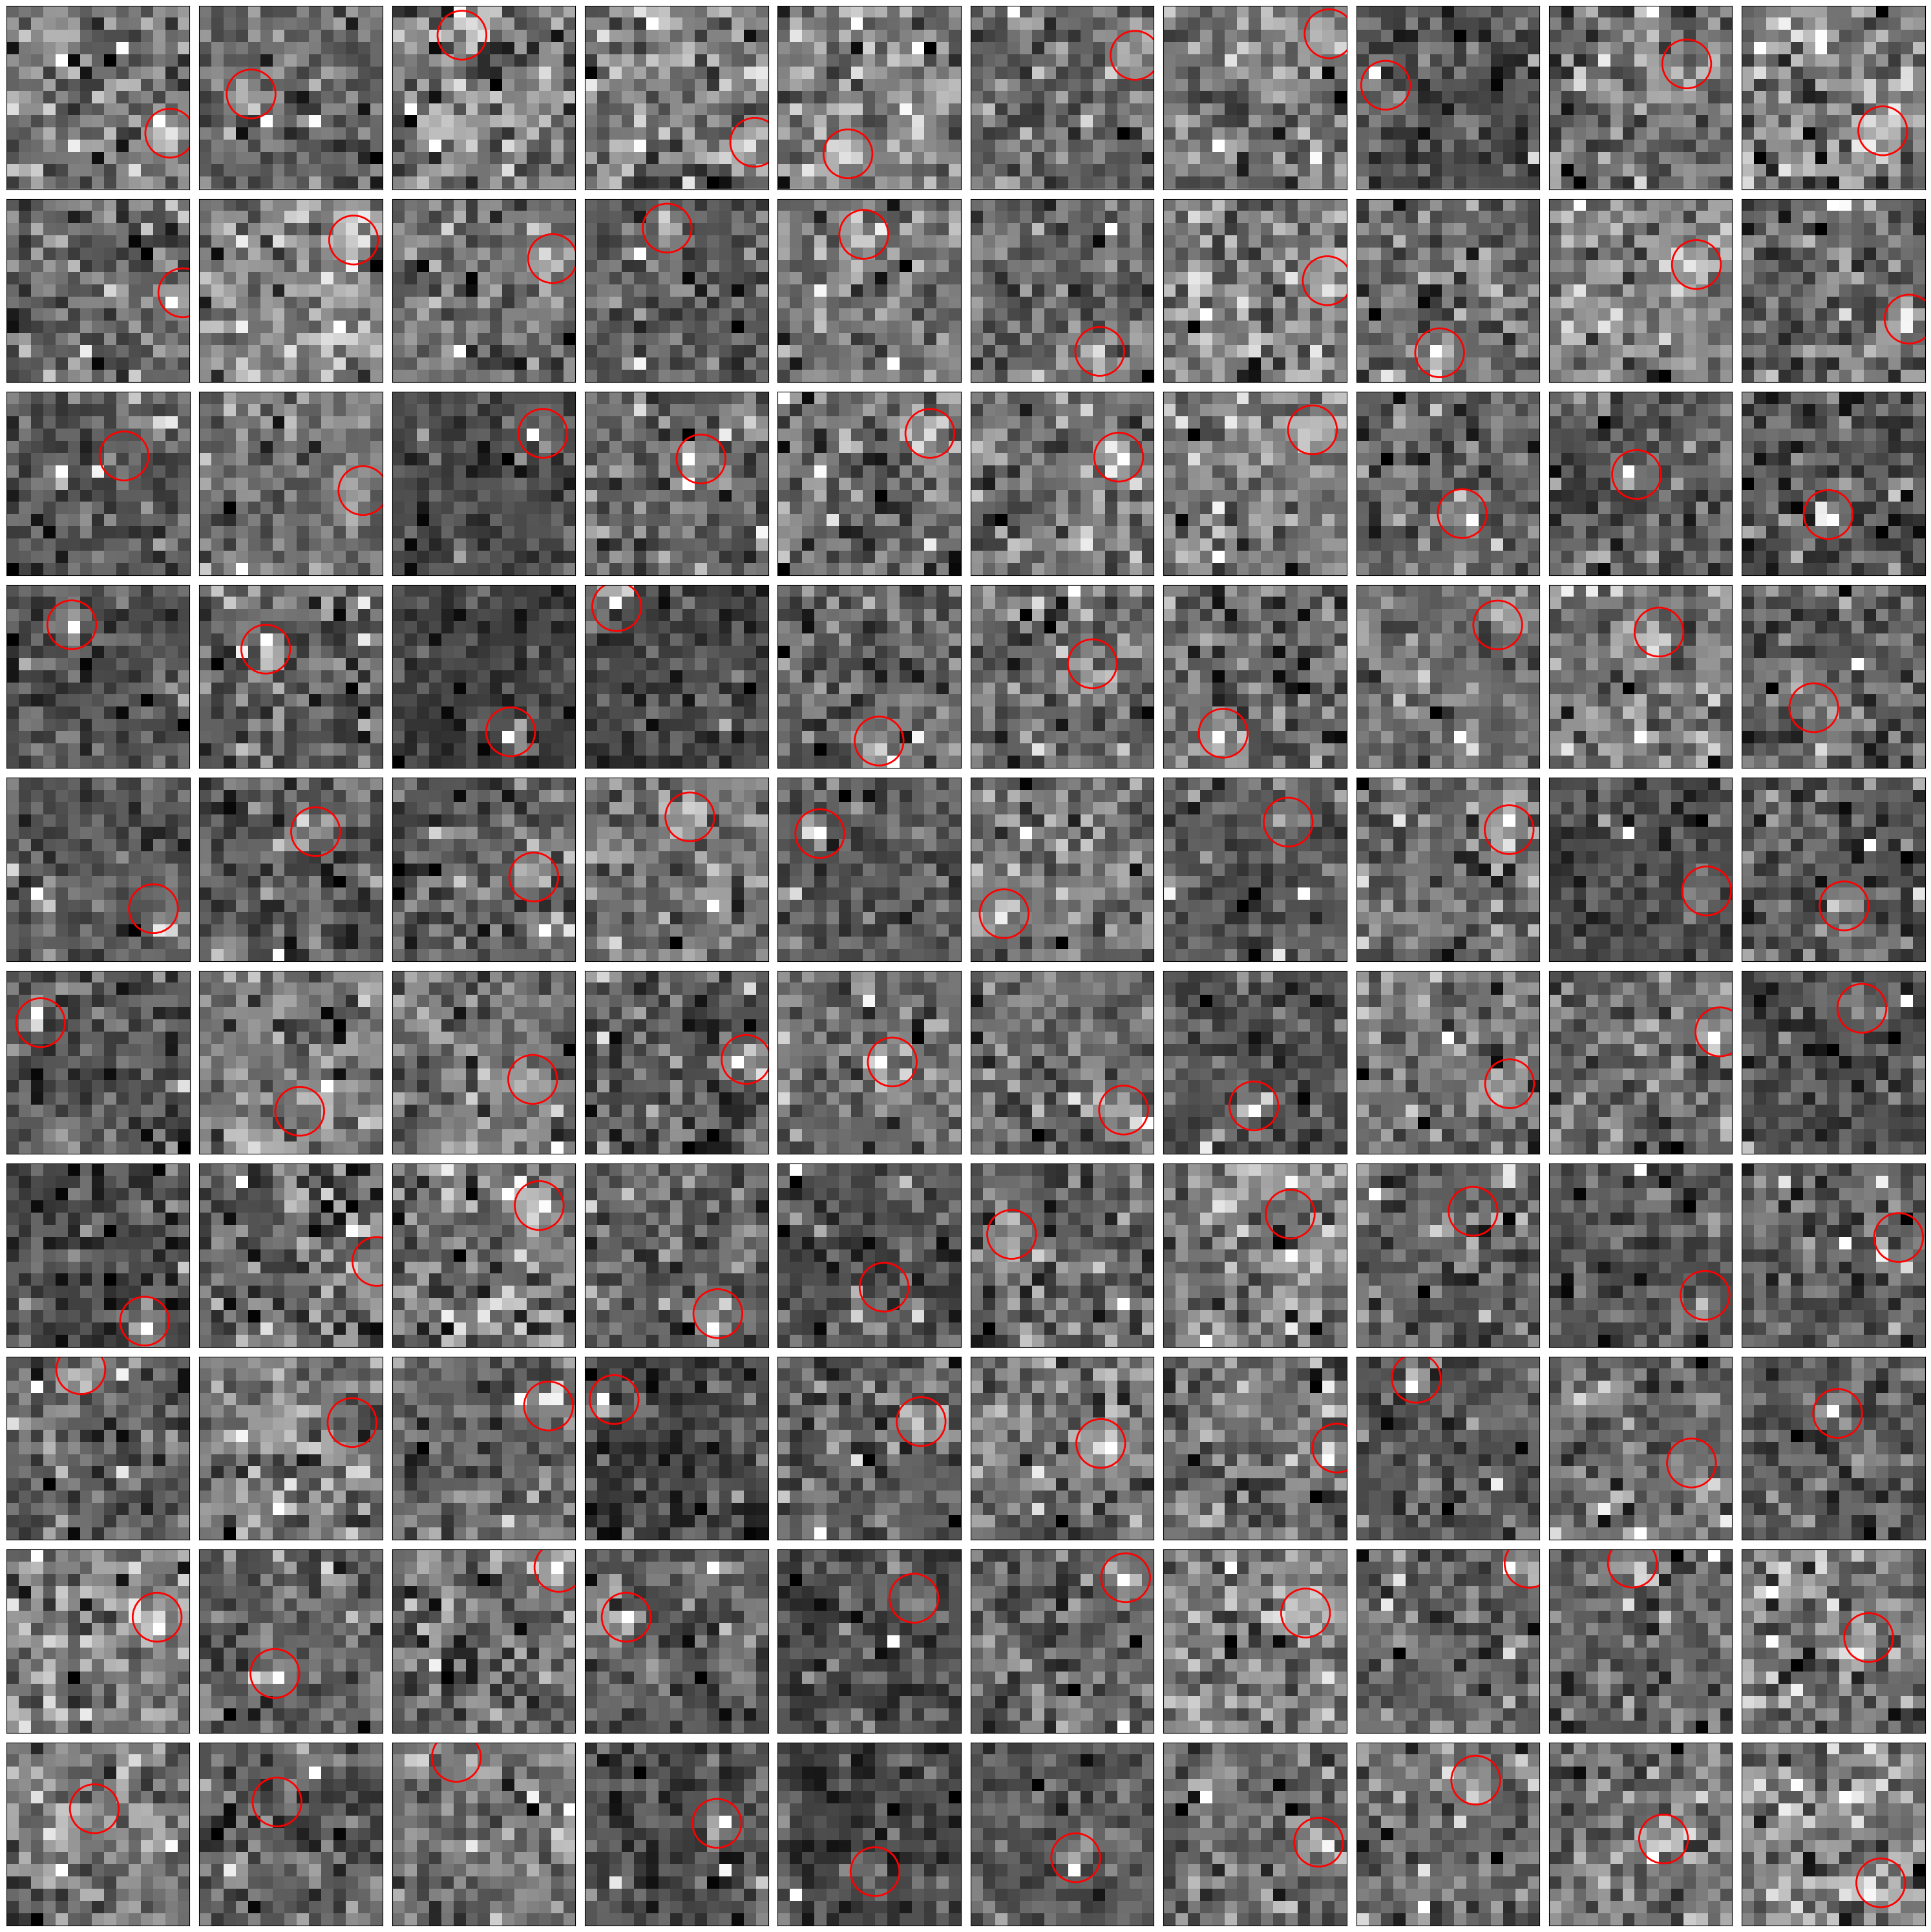

In [27]:

model = tf.keras.models.load_model("v1_asteroid_coord_regressor.keras")

images = np.load("./Searches/v3_images_pt4.npy")

if images.ndim == 3:
    images = np.expand_dims(images, axis=-1)
coords = model.predict(images)

# np.save("./Searches/v3_predicted_CoordinatesPixels_pt4.npy", coords)

import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

subset_images= images[:]

nrows, ncols = 10, 10
num_plots = nrows * ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
axes = axes.flatten()

for i in range(num_plots):
    ax = axes[i]
    if i >= len(subset_images):
        ax.axis('off')
        continue
    
    # Show the image
    img_2d = subset_images[i, :, :, 0]
    ax.imshow(img_2d, origin='lower', cmap='gray')

    # Draw the predicted coordinate as a red circle
    x_pred, y_pred = coords[i]
    circle = patches.Circle((x_pred, y_pred), radius=2.0, fill=False,
                            edgecolor='red', linewidth=2)
    ax.add_patch(circle)

    ax.set_xlim(-0.5, 14.5)
    ax.set_ylim(-0.5, 14.5)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [23]:
len(coords)

153226

# Convert Coords to ras, decs

In [7]:
import kevlib as kl

%run $kl.common_import_script


import requests
import urllib.parse
from astropy.io import ascii as astro_ascii
from astropy.io import fits



from kevlib import common_import_script
%run $common_import_script
from astropy.coordinates import SkyCoord
from astroscrappy import detect_cosmics
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
import lmfit
from astropy.io import fits
from kevlib.utils.plot import plot_images
from glob import glob
import kevlib.image as kli
from kevlib.utils import fix_byte_order
import urllib.parse
from astropy.io import ascii as astro_ascii
from scipy.ndimage import binary_dilation, binary_erosion


import shapely
from shapely.geometry import Polygon, Point

def is_point_inside_bounding_area(bounding_points, point_to_check):
    # Create a Polygon from the bounding points
    polygon = Polygon(bounding_points)
    
    # Create a Point object from the point to check
    point = Point(point_to_check)
    
    # Check if the point is within the polygon
    return polygon.contains(point)

def get_wcs(header):
    
    from astropy.wcs import WCS
    
    return WCS(header)


def get_frame_corners(wcs, header, mode=['equ', 'deg']):
    
    import astropy.units as u
    
    w = wcs
    
    end = header['NAXIS1'] - 1
    
    pixel_coords = [[0,0], [0, end], [end, end], [end, 0]]
    
    world_coords = []
    if 'equ' in mode:
        for c in pixel_coords:
            sky_coord = w.pixel_to_world(c[1],c[0])
            if 'rad' in mode:
                world_coords.append([sky_coord.ra.wrap_at(180*u.deg).rad, sky_coord.dec.rad])
            elif 'deg' in mode:
                world_coords.append([sky_coord.ra.deg, sky_coord.dec.deg])
            
    elif 'ecliptic' in mode:
        for c in pixel_coords:
            sky_coord = w.pixel_to_world(c[1],c[0]).geocentrictrueecliptic
            if 'rad' in mode:
                world_coords.append([sky_coord.lon.wrap_at(180*u.deg).rad, sky_coord.lat.rad])
            elif 'deg' in mode:
                world_coords.append([sky_coord.lon.deg, sky_coord.lat.deg])
    
    if mode == []:
        for c in pixel_coords:
            world_coords.append(w.pixel_to_world(c[1],c[0]))
    
    world_coords = np.vstack(world_coords)
    
    return world_coords

from astropy.stats import sigma_clipped_stats


def reduced_chi_squared(observed, expected, sigma, num_parameters):

    N = np.size(observed)
    nu = N - num_parameters
    chi2 = np.sum((observed - expected)**2 / sigma**2)
    chi2_red = chi2 / nu
    return chi2_red# Imports

/media/rd1/kwillis/kevlib_dev/src/kevlib/common_imports.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange  # 231010


---------------------------------------------------------------------------------------
|                        Last run date: 2025-07-01 08:37 PM E                         |
---------------------------------------------------------------------------------------
| Python | Jupyterlab | Numpy  | Scipy  | Astropy | Matplotlib | Tensorflow | Pytorch |
---------------------------------------------------------------------------------------
| 3.11.4 |   4.4.3    | 1.24.3 | 1.11.1 |  5.3.1  |   3.8.3    |   2.13.1   |  2.0.1  |
---------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------
|                        Last run date: 2025-07-01 08:37 PM E                         |
---------------------------------------------------------------------------------------
| Python | Jupyterlab | Numpy  | Scipy  | Astropy | Matplotlib | Tensorflow | Pytorch |
---------------------------------------------------------------------------------------
| 3.11.4 |   4.4.3    | 1.24.3 | 1.11.1 |  5.3.1  |   3.8.3    |   2.13.1   |  2.0.1  |
---------------------------------------------------------------------------------------


In [8]:
len(detIndexes)

153226

In [46]:
# detIndexes = np.load("Searches/v3_detIndexes_pt9_S1.npy")
# len(detIndexes)

In [9]:
ast_coords = np.load("./Searches/v3_predicted_CoordinatesPixels_pt4.npy")
len(ast_coords)

153226

In [10]:
ast_coords = np.load("./Searches/v3_predicted_CoordinatesPixels_pt4.npy")

all_grids = np.load("./Searches/2_S1_DarkPixelsRemoved_Normalized_FinalDeployGrids.npy")
urls = np.load("./Searches/S1_URLs.npy")
grid_coords = np.load("./Searches/S1_corners.npy")

ras = []
decs = []
mjds = []

from tqdm import tqdm
for i in tqdm(range(len(detIndexes))):
        
    xc = grid_coords[detIndexes[i]][0]
    yc = grid_coords[detIndexes[i]][1]

    hdul = fits.open(urls[detIndexes[i]])
    header = hdul[0].header # Extract the image header containing WCS info
    mjd = header["MJD_OBS"]
    
    wcs = get_wcs(header)

    xc += ast_coords[i][0]
    yc += ast_coords[i][1]
    
    sky = wcs.pixel_to_world(xc, yc)
    ra = sky.ra.degree
    dec = sky.dec.degree 
    
    ras.append(ra)
    decs.append(dec)
    mjds.append(mjd)
    hdul.close()

100%|██████████| 153226/153226 [1:18:32<00:00, 32.51it/s]


In [11]:
np.save("./S1_v3_Results/pt4_RAs_CoordCNN.npy", ras)
np.save("./S1_v3_Results/pt4_Decs_CoordCNN", decs)
np.save("./S1_v3_Results/pt4MJDs_CoordCNN", mjds)

In [12]:
len(ras)

153226

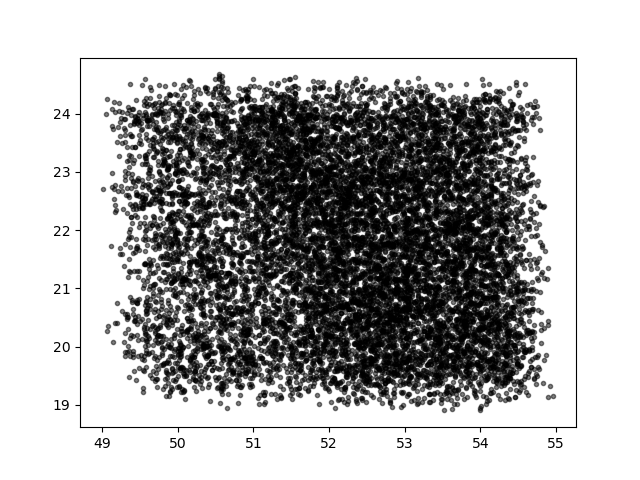

In [18]:
plt.figure()
plt.plot(ras,decs,".k",alpha=0.5)

# Cross Check with IRSA database

In [22]:
# ras

In [38]:
from astropy.table import Table
import pandas as pd

data = {
    "ra": ras[0:2],
    "dec": decs[0:2]
}

data = pd.DataFrame(data)

data_out = Table.from_pandas(data)
output_path = './data_out_rd.tbl'

data_out.write(output_path, format='ipac', overwrite=True)

In [63]:
min(mjds)

59805.21941061

(array([ 4081., 11334., 12439., 11869., 12397., 11051., 22434., 15539.,
        11203.,  4146.]),
 array([59805.21941061, 59806.06074323, 59806.90207585, 59807.74340847,
        59808.58474109, 59809.42607372, 59810.26740634, 59811.10873896,
        59811.95007158, 59812.7914042 , 59813.63273682]),
 <BarContainer object of 10 artists>)

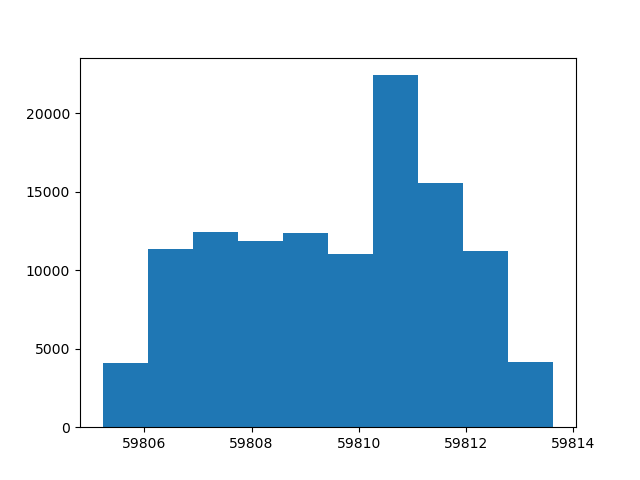

In [62]:
plt.figure()
plt.hist(mjds)